# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

In [ ]:
### Documentation of dataset: https://www.kaggle.com/vikrishnan/boston-house-prices

# - CRIM: crime rate by town 
# - ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
# - INDUS: proportion of non-retail business acres per town 
# - CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
# - NOX: nitric oxides concentration (parts per 10 million) 
# - RM: average number of rooms per dwelling 
# - AGE: proportion of owner-occupied units built prior to 1940 
# - DIS: weighted distances to five Boston employment centres 
# - RAD: index of accessibility to radial highways 
# - TAX: full-value property-tax rate per $10,000
#     - The full value tax rate represents the estimated tax rate for a municipality if all the taxable 
#       property was assessed at 100% and includes the equalized value of properties for which a payment 
#       in lieu of property taxes is made.
# - PTRATIO: pupil-teacher ratio by town 
# - Black: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
# - LSTAT: % lower status of the population (Proportion of population that is lower status) 
# - MEDV: Median value of owner-occupied homes in $1000's

### Import and explore the data. Clean the data for outliers and missing values. 

In [18]:
import pandas as pd 
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

boston = pd.read_csv(r"C:\Users\HP\Documents\IronHack\Bootcamp\IronHackLessons\Week7\LAB Problems in ML\data\boston_data.csv")

display(boston.head())

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [24]:
boston.shape

(404, 14)

In [25]:
boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.730912,10.509901,11.189901,0.069307,0.556710,6.30145,68.601733,3.799666,9.836634,411.688119,18.444554,355.068243,12.598936,22.312376
std,8.943922,22.053733,6.814909,0.254290,0.117321,0.67583,28.066143,2.109916,8.834741,171.073553,2.150295,94.489572,6.925173,8.837019
min,0.006320,0.000000,0.460000,0.000000,0.392000,3.56100,2.900000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,0.000000,0.453000,5.90275,45.800000,2.087875,4.000000,281.000000,17.375000,374.710000,7.135000,17.100000
50%,0.253715,0.000000,9.795000,0.000000,0.538000,6.23050,76.600000,3.207450,5.000000,330.000000,19.000000,391.065000,11.265000,21.400000
75%,4.053158,12.500000,18.100000,0.000000,0.631000,6.62925,94.150000,5.222125,24.000000,666.000000,20.200000,396.007500,16.910000,25.000000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.78000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.370000,50.000000


In [19]:
boston.dtypes

crim       float64
zn         float64
indus      float64
chas       float64
nox        float64
rm         float64
age        float64
dis        float64
rad        float64
tax        float64
ptratio    float64
black      float64
lstat      float64
medv       float64
dtype: object

In [20]:
boston.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

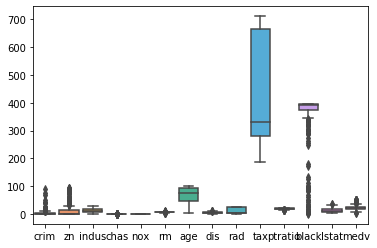

In [21]:
sns.boxplot(data=boston)

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

In [26]:
boston.corr()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
crim,1.000000,-0.194770,0.404249,-0.060688,0.405290,-0.172226,0.349288,-0.376493,0.603044,0.565047,0.292092,-0.377436,0.428940,-0.400956
zn,-0.194770,1.000000,-0.532268,-0.037290,-0.497114,0.302404,-0.546587,0.659018,-0.311313,-0.289332,-0.371315,0.176350,-0.412075,0.355608
indus,0.404249,-0.532268,1.000000,0.059928,0.760913,-0.353589,0.630048,-0.702583,0.616375,0.722828,0.356549,-0.378189,0.608309,-0.501698
chas,-0.060688,-0.037290,0.059928,1.000000,0.100650,0.090146,0.084852,-0.103124,-0.022561,-0.043708,-0.121835,0.042580,-0.041061,0.141400
nox,0.405290,-0.497114,0.760913,0.100650,1.000000,-0.266114,0.728882,-0.762469,0.612115,0.660607,0.166715,-0.393876,0.587573,-0.439225
rm,-0.172226,0.302404,-0.353589,0.090146,-0.266114,1.000000,-0.210589,0.178700,-0.173222,-0.241733,-0.323330,0.128410,-0.578025,0.683541
age,0.349288,-0.546587,0.630048,0.084852,0.728882,-0.210589,1.000000,-0.734915,0.467341,0.503830,0.231820,-0.276469,0.602001,-0.390863
dis,-0.376493,0.659018,-0.702583,-0.103124,-0.762469,0.178700,-0.734915,1.000000,-0.503471,-0.526938,-0.206016,0.306445,-0.500912,0.264876
rad,0.603044,-0.311313,0.616375,-0.022561,0.612115,-0.173222,0.467341,-0.503471,1.000000,0.917344,0.487733,-0.468700,0.499279,-0.423508
tax,0.565047,-0.289332,0.722828,-0.043708,0.660607,-0.241733,0.503830,-0.526938,0.917344,1.000000,0.465997,-0.462250,0.542732,-0.495792


LinregressResult(slope=8.93784218746435, intercept=-34.00899383924782, rvalue=0.683540993926214, pvalue=6.285608851947218e-57, stderr=0.47602051281021796)
LinregressResult(slope=-0.9477329129723657, intercept=34.25280221545037, rvalue=-0.7426954940642156, pvalue=5.168035689275097e-72, stderr=0.04261834664477085)


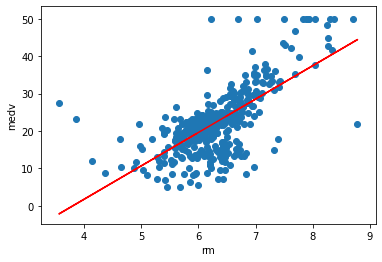

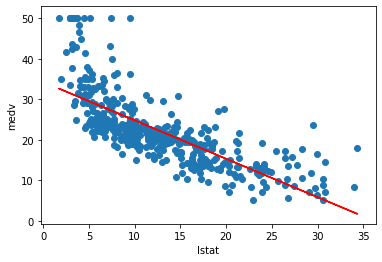

In [31]:
# sns.regplot(x="lstat",y="medv",data=boston) 
# sns.regplot(x="rm",y="medv",data=boston) 
# vou antes fazer assim, é melhor visualmente

x1 = boston["rm"]
y1 = boston["medv"]

x2 = boston["lstat"]
y2 = boston["medv"]


results1 = stats.linregress(x1,y1)
print(results1)

results2 = stats.linregress(x2,y2)
print(results2)

regression_line1 = results1.intercept + results1.slope*x1
regression_line2 = results2.intercept + results2.slope*x2

plt.plot(x1, regression_line1, c="red")
plt.scatter(x1,y1)
plt.xlabel("rm")
plt.ylabel("medv")
plt.show()

plt.plot(x2, regression_line2, c="red")
plt.scatter(x2,y2)
plt.xlabel("lstat")
plt.ylabel("medv")
plt.show()

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [ ]:
# just choose the most positive relation with the target (rm) and the most negative (lstat)

# it seems that when lstat goes up, medv goes down (strong negative corr). 
# Faz sentido, pois quando menos pop houver na zona, mais barata a casa fica.

# it seems that when rm goes up, medv also goes up (positive corr).
# Faz sentido, quantos mais divisões/maior a casa for, mais cara fica.

# So, the negative corr features to the target negatively impact medv
# and the positive corr features to the target positively impact medv

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

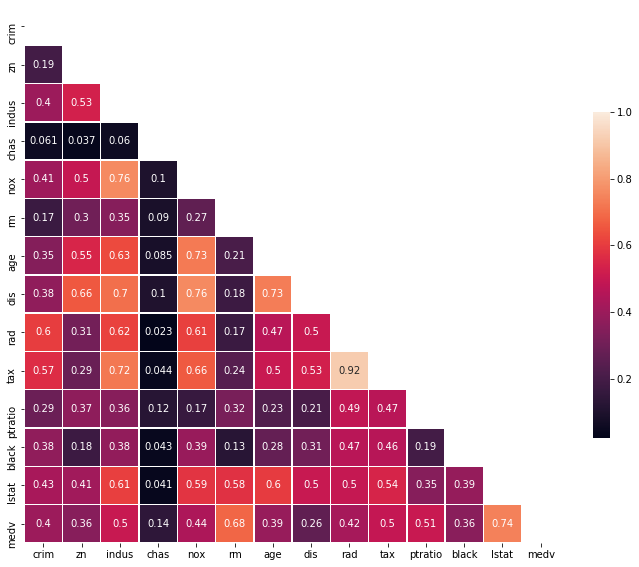

In [32]:
# correlation matrix
corr = np.abs(boston.corr())

# mask (for triangle representation)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# costruir a figura matplotlib
f, ax = plt.subplots(figsize=(12,12))
# gerar diverging colormap
cmap = sns.diverging_palette(220,20,as_cmap=True)
# desenhar heatmap com a mask e corrigir aspect ratio
sns.heatmap(corr, mask=mask, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=corr)

plt.show()

In [ ]:
# Tax and Rad have a really high positive corr
# and obviously thats a lot of negative corr and a good amount are highly negative

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [34]:
boston["medv"].describe()

count    404.000000
mean      22.312376
std        8.837019
min        5.000000
25%       17.100000
50%       21.400000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [90]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_pred):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    return r2_score(y_true,y_pred)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [91]:
from sklearn.model_selection import train_test_split

x = boston.loc[:, boston.columns != "medv"]
y = boston["medv"]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [100]:
from sklearn.ensemble import RandomForestRegressor

depth_var = [2,4,6,8,10]


# criar modelo (Train set)
def forest_train_score_depth_var(depth_var_list):
    models_score = []
    for depths in depth_var_list: 
        forest = RandomForestRegressor(n_estimators=10, # mesmas 10 trees
                                       max_depth=depths,
                                       random_state=1)
        # treinar modelo
        forest.fit(x_train, y_train)
        # modelo Score
        models_score.append(forest.score(x_train,y_train))
    
        # zippar resultados
        results = zip(depth_var_list, models_score)
    return (list(results))


# criar modelo (Test set)
def forest_test_score_depth_var(depth_var_list):
    models_score = []
    for depths in depth_var_list: 
        forest = RandomForestRegressor(n_estimators=10, # mesmas 10 trees
                                       max_depth=depths,
                                       random_state=1)
        # treinar modelo
        forest.fit(x_train, y_train)
        # modelo Score
        models_score.append(forest.score(x_test,y_test))
    
        # zippar resultados
        results = zip(depth_var_list, models_score)
    return (list(results))


print(forest_train_score_depth_var(depth_var))
print(forest_test_score_depth_var(depth_var))

[(2, 0.7548378434589322), (4, 0.8960163792804802), (6, 0.9315787665310388), (8, 0.9455449442189883), (10, 0.9535200021553943)]
[(2, 0.8099054146257894), (4, 0.8386615677292976), (6, 0.8428248395493412), (8, 0.8478769350387488), (10, 0.8310996659411003)]


Now, plot the score for each tree on the training set and on the testing set.

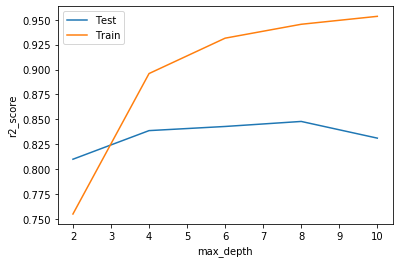

In [101]:
# Produce a plot with the score for the testing and training for the different max depths

x,y = zip(*forest_test_score_depth_var(depth_var))
z,r = zip(*forest_train_score_depth_var(depth_var))

plt.plot(x,y, label="Test")
plt.plot(z,r, label="Train")
plt.xlabel("max_depth")
plt.ylabel("r2_score")
plt.legend()
plt.show()


# precisei de alguma ajuda para o Plot (não estava a conseguir fazer assing em x,y e z,r)

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [ ]:
# as we increase Max_depth, the Score also increases, until it reaches the optimal max_depth
# the optimal max_depth for the Test is 8 (after that, probably due to overfitting, starts do decrease)
# Score in Train is higher, simply because the model was trained on it 

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? Check out this article before answering: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

In [ ]:
What is Bias?
# diff entre avg prediction do modelo e valor correto q queremos prever
# modelo com High Bias: não presta atenção ao Training e simplifica demasiado o modelo (levando a erros no Training e Testing)


What is Variance?
# variação do model predicition para um certo data point/value, q nos diz o quão disperso a data está.
# modelo com High Variance: presta demasiada atenção ao Train, não generalizado assim no Testing (data q ainda não viu) 
# modelos assim têm altas performances no Training mas erram muito no Testing


Underfitting: 
#   - quando modelo não consegue seguir o padrão correto da data. 
#   - High Bias e Low Variance.
Overfitting: 
#   - quando modelo captura demasiado "noise"(padrões q não interessam tanto) conjuntamente com os padrões da data.
#   - acontece quando Treinamos o modelo com demasiado "noises"(provavelmente devido a má Data Cleaning e modelos não aconselháveis para aquele problema)
#   - Low Bias e High Variance


Why is Bias Variance Tradeoff?
# Se modelo for demasiado simplista e tiver poucas parâmetros -> High Bias e Low Variance (Underfitting)
# Se modelo for demasiado complexo e tiver muitos parâmetros -> Low Bias e High Variance (Overfitting)
# Portanto, temos q encontrar um Balanço sem q isto aconteça



# Respondendo ás perguntas:
Quando se treina um modelo com max_depth=1 -> Underfitting (High Bias e Low Variance)
Quando se treina um modelo com max_depth=10 -> Overfitting (Low Bias e High Variance)
Portanto, o Balanço perfeito é Low Bias e Low Variance (ou seja, nem poucos parâmetros, nem muitos)

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [102]:
# HyperParameters Lesson (ajuda a encontrar os melhores parâmetros para certo Modelo e problema)
# usar modelo construido em cima (RandomForest)


# RANDOM SEARCH
from sklearn.model_selection import RandomizedSearchCV


n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]  # nº trees na Random Forest

max_features = ["auto","sqrt"]  # nº features para considerar em cada split (pode ser non-numeric). Tbm pode-se usar em Grid Search

max_depth = [int(x) for x in np.linspace(10,110,num=11)]  # nº levels em cada "Tree"
max_depth.append(None)  # None: "não quero dar max_depth, escolhe tu" 

min_samples_split = [2,5,10]  # nº minimo de samples para splitar node  
min_samples_leaf = [1,2,4]  # nº minimo de samples para cada "leaf" node

bootstrap = [True,False]  # método de selecionar samples para Train em cada "Tree"



# Criar modelo (random grid)
random_grid = {"n_estimators": n_estimators,
               "max_features": max_features,
               "max_depth": max_depth,
               "min_samples_split": min_samples_split,
               "min_samples_leaf": min_samples_leaf,
               "bootstrap": bootstrap}

# temos q dizer quantas iterações queremos:
#   - n_iter: quando combinações random vamos tentar
#   - n_jobs: para paralelizar processo (tbm se pode usar em Grid Search)
random_search = RandomizedSearchCV(estimator=forest, param_distributions=random_grid, n_iter=10, cv=5, n_jobs=10)

# treinar modelo
model = random_search.fit(x_train,y_train)


print(model.best_params_)
print(model.best_score_)
print(model.score(x_test,y_test))

{'n_estimators': 1800, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
0.8333526926839836
0.8778200930929224


### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
1. depends on the data, but today things change really quickly (specially about housing market).
But if old data can help us, in certain situations, the predict something in the future, it all depends on the ML model.

2. Maybe could have a few categorical Features 

3. The model is decent enough, but it seems to exist to much variance on the dataset

4. no, two different areas that are crucial to establish housing prices